# Riassunto di quanto fatto finora
## Regressione Logistica
Partiamo dalla regressione logistica. Importiamo il mio metodo e quello preimplementato su un paio di dataset utili.

In [1]:
from tqdm import tqdm

import numpy as np
np.random.seed(0)  # keep the random seed of numpy fixed

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from time import time

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score

from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn import datasets
from sklearn.datasets import load_wine

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from sklearn.naive_bayes import GaussianNB as GNB

# Configure matplotlib
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def LogisticRegressionMia(data, labels, n_iter = 1000, tol = 1e-7, insert_interc = True):
    
    # Proviamo a stampare il tempo
    # Prendiamo il tempo iniziale
    
    t0 = time()
    
    data_work = data
    
    # Per prima cosa aggiungiamo la colonna per l'intercetta
    if insert_interc:
        data_work = np.insert(data_work, 0, 1, axis = 1)
    
    # Inizialmente proviamo a fissare beta = 0
    beta = np.zeros(len(data_work[0, :]))
    beta_store = [0]
    #print(beta)
    
    # Poi dobbiamo creare il vettore di fitted probabilities p
    p = np.ones(len(labels))
    diagonale = np.zeros(len(labels))
    
    # Ora dobbiamo ripetere queste operazione
    for n in range(n_iter):
        
        # Usiamo i cicli for e poi vediamo di passare allo slicing
        for i in range(len(labels)):
            h = beta @ data_work[i, :]
            elemento = ((np.e)**h) / (1+(np.e)**h)
            #print(elemento)
            #print(np.e**h / (1+np.e**h))
            p[i] = elemento
            #print(p[i])
            diagonale[i] = p[i]*(1 - p[i])
        
        #diagonale[:] = p[:]*(1 - p[:])
            
        #print(p)

        # Ora creiamo la matrice W: questa è una prima implementazione grezza,
        # vedi coem creare le matrici diagonali
        W = np.diagflat(diagonale)
        #print(W)

        # A questo punto definisco il vettore z
        W_inv = np.linalg.inv(W)
        z = np.dot(data_work, beta) + np.dot(W_inv, labels-p)

        # Ora calcolo il nuovo b
        a = np.dot(data_work.T, W)
        c = np.dot(a, data_work)
        d = np.linalg.inv(c)
        f = np.dot(data_work.T, W)
        g = np.dot(d, f)
        beta = np.dot(g, z)
        
        beta_store.append(beta)
        
        if (np.linalg.norm(beta_store[-1] - beta_store[-2]) < tol):
            break
    
    print(f"Regressione effettuata in: {time() - t0} s.")
        
    return beta

In [3]:
def compara_lr(data, labels, data_val = None, y_val = None, n_iter = 1000, tol = 1e-7, 
               insert_interc = True, solver = 'newton-cholesky', penalty = None):
    
    beta = LogisticRegressionMia(data, labels, n_iter, tol, insert_interc)
    print(f"I coefficienti della mia regressione lineare sono dati da: {beta}")
    
    t0 = time()
    logreg = LogisticRegression(solver = solver, penalty = penalty).fit(data, labels)
    
    print(f"La regressione logistica preimplementata è stata eseguita in: {time() - t0} s")
    
    coef_logreg = []
    coef_logreg.append(logreg.intercept_[0])
    for i in range(len(logreg.coef_[0])):
        coef_logreg.append(logreg.coef_[0, i])
    
    print(f"I coefficienti della regressione lineare preimplementata sono dati da: {coef_logreg}")
    
    return beta, coef_logreg



In [4]:
# Funzione per predirre la classe, nel caso di due classi

def predict(data, coef_model, soglia = 0.5, insert_interc = True):
    
    t0 = time()
    
    predict = []
    len_feature = len(data[0])
    data_work = data
    
    if insert_interc:
        data_work = data_work = np.insert(data_work, 0, 1, axis = 1)
        
    # Facciamo un ciclo sui dati che possediamo
    
    for i in range(len(data_work)):
        scalare = np.inner(data_work[i], coef_model)
        prob = np.e**(scalare) / (1 + np.e**(scalare))
        
        if (prob <= soglia):
            predict.append(0)
        else:
            predict.append(1)
    
    print(f"Predizione mia effettuata in: {time() - t0} s.")
    
    return predict

In [5]:
# Compariamo le accuratezze

def calcola_acc_mia(data, pred_real, coef_model, soglia = 0.5, insert_interc = True):
    
    y_pred_mia = predict(data, coef_model, soglia = 0.5, insert_interc = True)
    acc_mia = accuracy_score(pred_real, y_pred_mia)
    
    print(f"Accuratezza della mia predizione: {acc_mia}")
    

In [6]:
# Funzione per confrontare regressione logistica, LDA, QDA e Naive Bayes

def confronta_soglie(X_input, y_input, minval = -2, maxval = 2, plot = True):
    
    logreg_base = LogisticRegression(penalty = None, solver = 'newton-cholesky').fit(X_input, y_input)
    
    X_train1, X_val1, y_train1, y_val1 = train_test_split(X_input, y_input, train_size = 0.7, random_state = 1)
    logreg1 = LogisticRegression(penalty = None, solver = 'newton-cholesky').fit(X_train1, y_train1)
    
    X_train2, X_val2, y_train2, y_val2 = train_test_split(X_input, y_input, train_size = 0.6, random_state = 2)
    logreg2 = LogisticRegression(penalty = None, solver = 'newton-cholesky').fit(X_train2, y_train2)
    
    X_train3, X_val3, y_train3, y_val3 = train_test_split(X_input, y_input, train_size = 0.5, random_state = 3)
    logreg3 = LogisticRegression(penalty = None, solver = 'newton-cholesky').fit(X_train3, y_train3)
    
    LDA_base = LDA().fit(X_input, y_input)
    QDA_base = QDA().fit(X_input, y_input)
    NB_base = GNB().fit(X_input, y_input)
    
    LDA1 = LDA().fit(X_train1, y_train1)
    QDA1 = QDA().fit(X_train1, y_train1)
    NB1 = GNB().fit(X_train1, y_train1)
    
    LDA2 = LDA().fit(X_train2, y_train2)
    QDA2 = QDA().fit(X_train2, y_train2)
    NB2 = GNB().fit(X_train2, y_train2)
    
    LDA3 = LDA().fit(X_train3, y_train3)
    QDA3 = QDA().fit(X_train3, y_train3)
    NB3 = GNB().fit(X_train3, y_train3)
    
    # Predizioni
    y_pred = logreg_base.predict(X_input)
    y_pred_1 = logreg1.predict(X_val1)
    y_pred_2 = logreg2.predict(X_val2)
    y_pred_3 = logreg3.predict(X_val3)
    
    y_pred_lda = LDA_base.predict(X_input)
    y_pred_lda1 = LDA1.predict(X_val1)
    y_pred_lda2 = LDA2.predict(X_val2)
    y_pred_lda3 = LDA3.predict(X_val3)
    
    y_pred_qda = QDA_base.predict(X_input)
    y_pred_qda1 = QDA1.predict(X_val1)
    y_pred_qda2 = QDA2.predict(X_val2)
    y_pred_qda3 = QDA3.predict(X_val3)
    
    y_pred_nb = NB_base.predict(X_input)
    y_pred_nb1 = NB1.predict(X_val1)
    y_pred_nb2 = NB2.predict(X_val2)
    y_pred_nb3 = NB3.predict(X_val3)
    
    # Accuratezze
    
    acc = accuracy_score(y_input, y_pred)
    acc_1 = accuracy_score(y_val1, y_pred_1)
    acc_2 = accuracy_score(y_val2, y_pred_2)
    acc_3 = accuracy_score(y_val3, y_pred_3)
    
    acc_lda = accuracy_score(y_input, y_pred_lda)
    acc_lda1 = accuracy_score(y_val1, y_pred_lda1)
    acc_lda2 = accuracy_score(y_val2, y_pred_lda2)
    acc_lda3 = accuracy_score(y_val3, y_pred_lda3)
    
    acc_qda = accuracy_score(y_input, y_pred_qda)
    acc_qda1 = accuracy_score(y_val1, y_pred_qda1)
    acc_qda2 = accuracy_score(y_val2, y_pred_qda2)
    acc_qda3 = accuracy_score(y_val3, y_pred_qda3)
    
    acc_nb = accuracy_score(y_input, y_pred_nb)
    acc_nb1 = accuracy_score(y_val1, y_pred_nb1)
    acc_nb2 = accuracy_score(y_val2, y_pred_nb2)
    acc_nb3 = accuracy_score(y_val3, y_pred_nb3)
    
    print(f"Accuratezza della logistic regression: {acc}")
    print(f"Accuratezza della logistic regression 1: {acc_1}")
    print(f"Accuratezza della logistic regression 2: {acc_2}")
    print(f"Accuratezza della logistic regression 3: {acc_3}")
    
    print(f"Accuratezza della LDA base: {acc_lda}")
    print(f"Accuratezza della LDA 1: {acc_lda1}")
    print(f"Accuratezza della LDA 2: {acc_lda2}")
    print(f"Accuratezza della LDA 3: {acc_lda3}")
    
    print(f"Accuratezza della QDA base: {acc_qda}")
    print(f"Accuratezza della QDA 1: {acc_qda1}")
    print(f"Accuratezza della QDA 2: {acc_qda2}")
    print(f"Accuratezza della QDA 3: {acc_qda3}")
    
    print(f"Accuratezza della NB base: {acc_nb}")
    print(f"Accuratezza della NB 1: {acc_nb1}")
    print(f"Accuratezza della NB 2: {acc_nb2}")
    print(f"Accuratezza della NB 3: {acc_nb3}")
    
    # Disegni
    
    if plot:
    
        alpha = 0.5
        log_a = np.log((alpha) /  (1 -alpha))

        z_x = np.linspace(minval, maxval, 1000)
        z_y = np.zeros_like(z_x)
        z_y1 = np.zeros_like(z_x)
        z_y2 = np.zeros_like(z_x)
        z_y3 = np.zeros_like(z_x)
        z_y[:] = (log_a - logreg_base.intercept_[0] - logreg_base.coef_[0, 0]*z_x[:]) / (logreg_base.coef_[0,1])
        z_y1[:] = (log_a - logreg1.intercept_[0] - logreg1.coef_[0, 0]*z_x[:]) / (logreg1.coef_[0,1])
        z_y2[:] = (log_a - logreg2.intercept_[0] - logreg2.coef_[0, 0]*z_x[:]) / (logreg2.coef_[0,1])
        z_y3[:] = (log_a - logreg3.intercept_[0] - logreg3.coef_[0, 0]*z_x[:]) / (logreg3.coef_[0,1])

        plt.figure()
        plt.figure(figsize=(8, 8))
        plt.plot(z_x, z_y, label = "DB base")
        plt.plot(z_x, z_y1, label = "DB 1")
        plt.plot(z_x, z_y2, label = "DB 2")
        plt.plot(z_x, z_y3, label = "DB 3")
        plt.plot(X_input[:, 0][y_input == 1], X_input[:, 1][y_input == 1], "g^", label="Classe 1")
        plt.plot(X_input[:, 0][y_input == 0], X_input[:, 1][y_input == 0], "bs", label="Classe 2")
        plt.xlabel("Feature 1", fontsize=14)
        plt.ylabel("Feature 2", fontsize=14)
        plt.legend(loc="upper left", fontsize=10)
        plt.show()


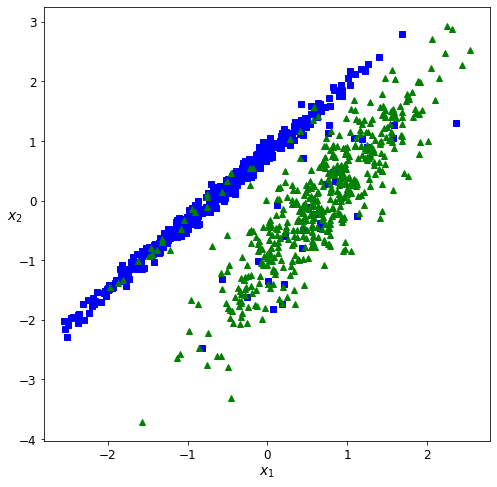

In [7]:
X_cluster, y_cluster = datasets.make_classification(n_samples=1000,
                                                    n_features=2,
                                                    n_redundant=0,
                                                    n_informative=2,
                                                    n_repeated=0,
                                                    n_clusters_per_class=1,
                                                    flip_y=0.1,
                                                    random_state=15,
                                                    )
# scale the data
scaler = StandardScaler()
X_cluster = scaler.fit_transform(X_cluster)

plt.figure(figsize=(8, 8))
plt.plot(X_cluster[:, 0][y_cluster == 0], X_cluster[:, 1][y_cluster == 0], "bs")
plt.plot(X_cluster[:, 0][y_cluster == 1], X_cluster[:, 1][y_cluster == 1], "g^")
plt.xlabel(r"$x_1$", fontsize=14)
plt.ylabel(r"$x_2$", fontsize=14, rotation=0)
plt.show()

In [8]:
# Per prima cosa dividiamo in training e validation set

X_cluster_train, X_cluster_val, y_cluster_train, y_cluster_val = train_test_split(X_cluster,
                                                                                  y_cluster, 
                                                                                  train_size = 0.7)

beta_cluster, coef_cluster = compara_lr(X_cluster_train, y_cluster_train)

Regressione effettuata in: 0.337460994720459 s.
I coefficienti della mia regressione lineare sono dati da: [ 0.23859315  3.86576226 -2.79345758]
La regressione logistica preimplementata è stata eseguita in: 0.031874656677246094 s
I coefficienti della regressione lineare preimplementata sono dati da: [0.23858910199228564, 3.8657556025013182, -2.7934507622780633]


Direi che i risultati sono molto buoni. Proviamo ora a vedere come è l'accuratezza. Dovrei scrivere una funzione che assegna a ognuno dei dati il label corretto.

In [9]:
calcola_acc_mia(X_cluster_val, y_cluster_val, beta_cluster)

logreg_cluster = LogisticRegression(solver = 'newton-cholesky', penalty = None).fit(X_cluster_train, y_cluster_train)
y_cluster_pred = logreg_cluster.predict(X_cluster_val)
acc_cluster = accuracy_score(y_cluster_val, y_cluster_pred)
print(f"Accuratezza della predizione preimplementata: {acc_cluster}")

Predizione mia effettuata in: 0.002607107162475586 s.
Accuratezza della mia predizione: 0.9433333333333334
Accuratezza della predizione preimplementata: 0.9433333333333334


Utilizziamo ora il dataset Iris: ne prendiamo solo due feature che ci permettono di lavorare con dati che sono rappresentabili in un piano così da poter eventualmente plottare il risultato.

In [10]:
iris = datasets.load_iris()
#print(iris.DESCR)
X_iris, y_iris = iris.data, iris.target

# Prendiamo solo due categorie

X_iris1 = iris["data"][:, (2, 3)]  # petal length, petal width
y_iris1 = (iris["target"] == 2).astype(int)  # make problem binary: 1 if Iris virginica, else 0

beta_iris, coef_iris = compara_lr(X_iris1, y_iris1)

Regressione effettuata in: 0.0142059326171875 s.
I coefficienti della mia regressione lineare sono dati da: [-45.27234377   5.75453232  10.44669989]
La regressione logistica preimplementata è stata eseguita in: 0.014390707015991211 s
I coefficienti della regressione lineare preimplementata sono dati da: [-45.268568663374225, 5.753990540127247, 10.44602888094423]


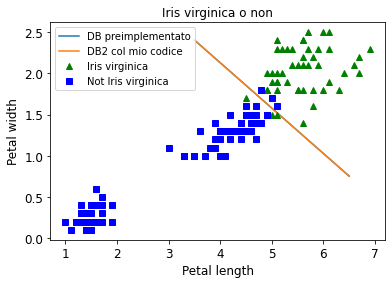

In [11]:
# Visualizziamo graficamente il risultato

alpha = 0.5
log_a = np.log((alpha) /  (1 -alpha))

z_x = np.linspace(3.5, 6.5, 1000)
z_y = np.zeros_like(z_x)
z_y[:] = (log_a - coef_iris[0] - coef_iris[1]*z_x[:]) / (coef_iris[2])

z_y1  = (log_a - beta_iris[0] - beta_iris[1]*z_x[:]) / beta_iris[2]


plt.figure()
plt.title("Iris virginica o non")
plt.plot(z_x, z_y, label = "DB preimplementato")
plt.plot(z_x, z_y1, label = "DB2 col mio codice")
plt.plot(X_iris1[:, 0][y_iris1 == 1], X_iris1[:, 1][y_iris1 == 1], "g^", label="Iris virginica")
plt.plot(X_iris1[:, 0][y_iris1 == 0], X_iris1[:, 1][y_iris1 == 0], "bs", label="Not Iris virginica")
plt.xlabel("Petal length", fontsize=12)
plt.ylabel("Petal width", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.show()

In [12]:
# Accuratezza

calcola_acc_mia(X_iris1, y_iris1, beta_iris)

logreg_iris = LogisticRegression(solver = 'newton-cholesky', penalty = None).fit(X_iris1, y_iris1)
y_iris_pred = logreg_iris.predict(X_iris1)
acc_iris = accuracy_score(y_iris_pred, y_iris1)
print(f"Accuratezza della predizione preimplementata: {acc_iris}")

Predizione mia effettuata in: 0.0009953975677490234 s.
Accuratezza della mia predizione: 0.96
Accuratezza della predizione preimplementata: 0.96


Vediamo cosa succede se prendiamo i dati ben separati da un iperpiano (dovrebbe un po' distruggersi la regressione logistica, proviamo)

In [13]:
X_iris2 = iris["data"][:, (2, 3)]  # petal length, petal width
y_iris2 = (iris["target"] == 0).astype(int)  # make problem binary: 1 if Iris virginica, else 0

#beta_iris2, coef_iris2 = compara_lr(X_iris2, y_iris2)
# Se provo a eseguire il mio codice mi restituisce una matrice singolare

# Proviamo a eseguire la regressione logistica preimplementata e vediamo se questa funziona

logreg_iris2 = LogisticRegression(solver = 'newton-cholesky', penalty = None).fit(X_iris2, y_iris2)

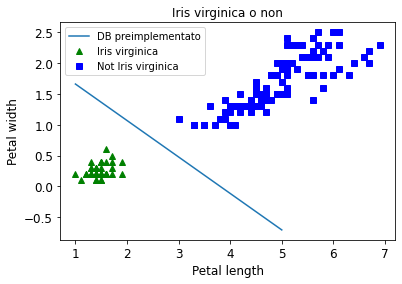

In [14]:
# Visualizziamo graficamente il risultato

alpha = 0.5
log_a = np.log((alpha) /  (1 -alpha))

z_x = np.linspace(1, 5, 1000)
z_y = np.zeros_like(z_x)
z_y[:] = (log_a - logreg_iris2.intercept_[0] - logreg_iris2.coef_[0,0]*z_x[:]) / (logreg_iris2.coef_[0,1])

#z_y1  = (log_a - beta_iris[0] - beta_iris[1]*z_x[:]) / beta_iris[2]


plt.figure()
plt.title("Iris virginica o non")
plt.plot(z_x, z_y, label = "DB preimplementato")
#plt.plot(z_x, z_y1, label = "DB2 col mio codice")
plt.plot(X_iris1[:, 0][y_iris2 == 1], X_iris1[:, 1][y_iris2 == 1], "g^", label="Iris virginica")
plt.plot(X_iris1[:, 0][y_iris2 == 0], X_iris1[:, 1][y_iris2 == 0], "bs", label="Not Iris virginica")
plt.xlabel("Petal length", fontsize=12)
plt.ylabel("Petal width", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.show()

Quella preimplementata però funziona: probabilmente ha qualcosa che permette di calcolarlo in qualche modo, tipo mi getta fuori un errore.

## Confronto con LDA e QDA
Cerchiamo un dataset in cui effettivamente si noti un po' la differenza: dovrebbe essere abbastanza piccola però magari si nota. Con il dataset iris1 non sembra notarsi particolarmente la differenza.

Accuratezza della logistic regression: 0.96


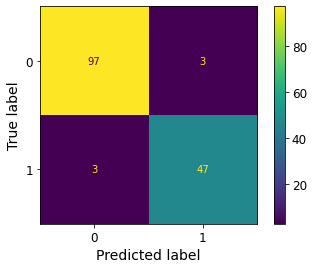

Accuratezza della LDA: 0.9466666666666667


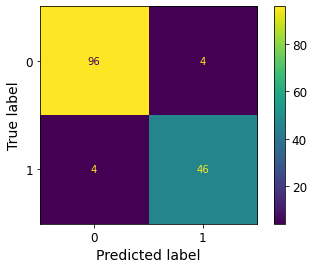

Accuratezza della QDA: 0.98


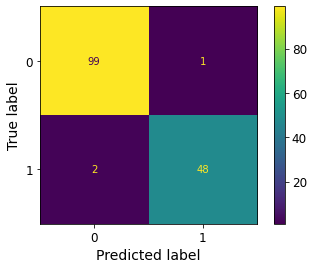

Accuratezza del Naive Bayes: 0.96


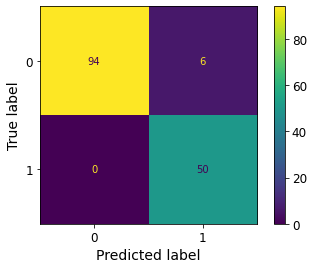

In [15]:

LDA_cluster = LDA().fit(X_iris1, y_iris1)
QDA_cluster = QDA().fit(X_iris1, y_iris1)
NB_cluster = GNB().fit(X_iris1, y_iris1)
LR_cluster = LogisticRegression(penalty=None).fit(X_iris1, y_iris1)

y_pred_lda = LDA_cluster.predict(X_iris1)
y_pred_qda = QDA_cluster.predict(X_iris1)
y_pred_nb = NB_cluster.predict(X_iris1)
y_pred_lr = LR_cluster.predict(X_iris1)

acc_lr = accuracy_score(y_iris1, y_pred_lr)
acc_lda = accuracy_score(y_iris1, y_pred_lda)
acc_qda = accuracy_score(y_iris1, y_pred_qda)
acc_nb = accuracy_score(y_iris1, y_pred_nb)

print(f"Accuratezza della logistic regression: {acc_lr}")

matrix_lr = confusion_matrix(y_iris1, y_pred_lr)
ConfusionMatrixDisplay(confusion_matrix = matrix_lr).plot()
plt.show()

print(f"Accuratezza della LDA: {acc_lda}")

matrix_lda = confusion_matrix(y_iris1, y_pred_lda)
ConfusionMatrixDisplay(confusion_matrix = matrix_lda).plot()
plt.show()

print(f"Accuratezza della QDA: {acc_qda}")

matrix_qda = confusion_matrix(y_iris1, y_pred_qda)
ConfusionMatrixDisplay(confusion_matrix = matrix_qda).plot()
plt.show()

print(f"Accuratezza del Naive Bayes: {acc_nb}")

matrix_nb = confusion_matrix(y_iris1, y_pred_nb)
ConfusionMatrixDisplay(confusion_matrix = matrix_nb).plot()
plt.show()

Accuratezza della logistic regression: 0.9866666666666667


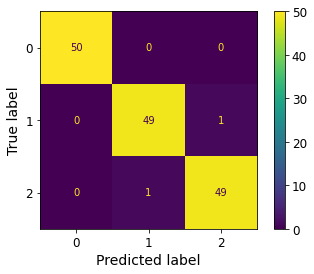

Accuratezza della LDA: 0.98


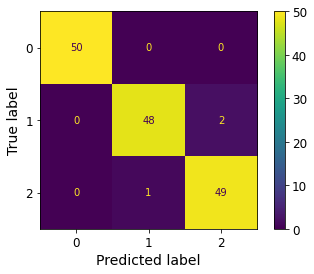

Accuratezza della QDA: 0.98


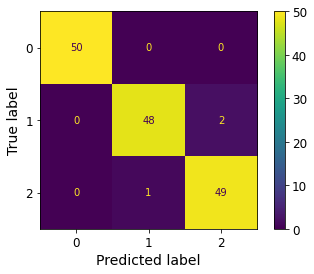

Accuratezza del Naive Bayes: 0.96


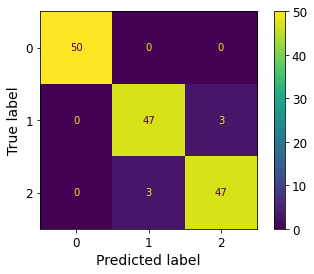

In [16]:
LDA_cluster = LDA().fit(X_iris, y_iris)
QDA_cluster = QDA().fit(X_iris, y_iris)
NB_cluster = GNB().fit(X_iris, y_iris)
LR_cluster = LogisticRegression(penalty=None).fit(X_iris, y_iris)

y_pred_lda = LDA_cluster.predict(X_iris)
y_pred_qda = QDA_cluster.predict(X_iris)
y_pred_nb = NB_cluster.predict(X_iris)
y_pred_lr = LR_cluster.predict(X_iris)

acc_lr = accuracy_score(y_iris, y_pred_lr)
acc_lda = accuracy_score(y_iris, y_pred_lda)
acc_qda = accuracy_score(y_iris, y_pred_qda)
acc_nb = accuracy_score(y_iris, y_pred_nb)

print(f"Accuratezza della logistic regression: {acc_lr}")

matrix_lr = confusion_matrix(y_iris, y_pred_lr)
ConfusionMatrixDisplay(confusion_matrix = matrix_lr).plot()
plt.show()

print(f"Accuratezza della LDA: {acc_lda}")

matrix_lda = confusion_matrix(y_iris, y_pred_lda)
ConfusionMatrixDisplay(confusion_matrix = matrix_lda).plot()
plt.show()

print(f"Accuratezza della QDA: {acc_qda}")

matrix_qda = confusion_matrix(y_iris, y_pred_qda)
ConfusionMatrixDisplay(confusion_matrix = matrix_qda).plot()
plt.show()

print(f"Accuratezza del Naive Bayes: {acc_nb}")

matrix_nb = confusion_matrix(y_iris, y_pred_nb)
ConfusionMatrixDisplay(confusion_matrix = matrix_nb).plot()
plt.show()

In [17]:
confronta_soglie(X_iris, y_iris, plot = False)

Accuratezza della logistic regression: 0.98
Accuratezza della logistic regression 1: 0.9555555555555556
Accuratezza della logistic regression 2: 0.95
Accuratezza della logistic regression 3: 0.92
Accuratezza della LDA base: 0.98
Accuratezza della LDA 1: 1.0
Accuratezza della LDA 2: 1.0
Accuratezza della LDA 3: 0.96
Accuratezza della QDA base: 0.98
Accuratezza della QDA 1: 1.0
Accuratezza della QDA 2: 0.9833333333333333
Accuratezza della QDA 3: 0.9333333333333333
Accuratezza della NB base: 0.96
Accuratezza della NB 1: 0.9333333333333333
Accuratezza della NB 2: 0.9333333333333333
Accuratezza della NB 3: 0.96


Proviamo ora con il make_moons dataset su cui dovrebbe vedersi un maggiore effetto della differenza. Creiamo il dataset e poi vediamo di implementarlo.

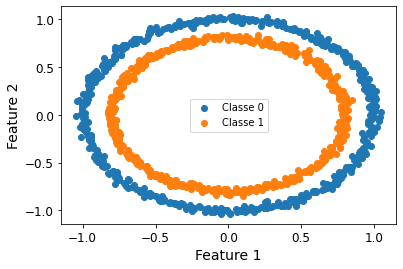

In [20]:
X_circles, y_circles = make_circles(n_samples = 1000, noise = 0.02, random_state = 1)

# Visualizzare il dataset
plt.scatter(X_circles[y_circles == 0][:, 0], X_circles[y_circles == 0][:, 1], label="Classe 0")
plt.scatter(X_circles[y_circles == 1][:, 0], X_circles[y_circles == 1][:, 1], label="Classe 1")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [23]:
confronta_soglie(X_circles, y_circles, minval = -1, maxval = 1, plot = False)

Accuratezza della logistic regression: 0.502
Accuratezza della logistic regression 1: 0.49
Accuratezza della logistic regression 2: 0.4675
Accuratezza della logistic regression 3: 0.486
Accuratezza della LDA base: 0.502
Accuratezza della LDA 1: 0.49
Accuratezza della LDA 2: 0.4675
Accuratezza della LDA 3: 0.486
Accuratezza della QDA base: 1.0
Accuratezza della QDA 1: 0.8866666666666667
Accuratezza della QDA 2: 0.83
Accuratezza della QDA 3: 0.96
Accuratezza della NB base: 1.0
Accuratezza della NB 1: 0.8833333333333333
Accuratezza della NB 2: 0.8425
Accuratezza della NB 3: 0.998


Direi che questo è un buon esempio per far capire che a volte la logistic regression funziona peggio della QDA e di altri metodi simili.